# Local linear network

In [1]:
import numpy as np
import sklearn
from nmf_with_missing_values import nmf_with_missing_values
import ipyvolume
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

## load the data

In [105]:
tmp = np.load('../data/mouse_brain_ISH_float32.npz')
data = tmp['data']
sections = tmp['sections'].item()
original_shape = data.shape
d = data.shape[1] * data.shape[2] * data.shape[3]
data = np.reshape(data, (data.shape[0], d))

## calculate nmf (could be quite long, do not run this chunk if you have the intermediate result

In [3]:
nmf = nmf_with_missing_values(n_outer_loops = 4, n_components = 14)
D = nmf.fit_transform(data)
A = nmf.components_

KeyboardInterrupt: 

## save the intermediate result

In [5]:
np.savez('tmp_result.npz', D = D, A = A, X_guess = nmf.X_guess, data = data, original_shape = original_shape)

## load the intermediate result 

In [16]:
f = np.load('../code/reza/nmf_result_ncomp_18.npz')
A = f['A']
original_shape = f['original_shape']
X_guess = f['X_guess']
coefs = f['D']

### reshape the dictionary

In [18]:
D_cube = A.reshape([18] + list(original_shape[1:])) 

In [19]:
assert np.allclose(D_cube[0,:], A[0, :].reshape(original_shape[1:]))

### look at 2D projections of each pattern

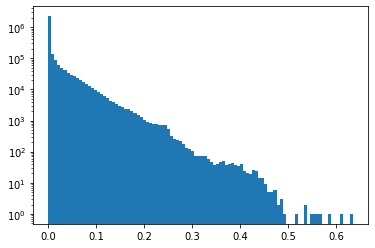

In [20]:
plt.hist(D_cube.flatten(), 100)
plt.yscale('log')
plt.show()

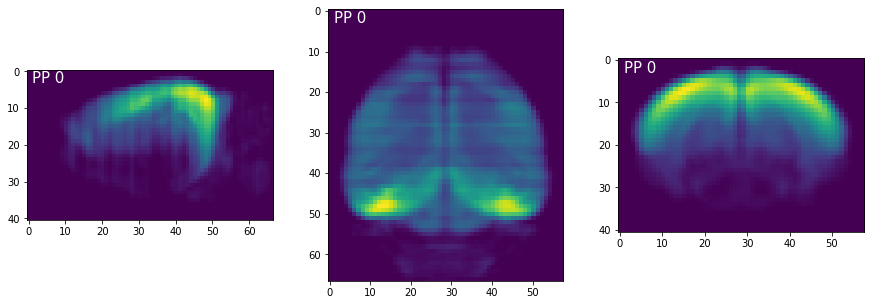

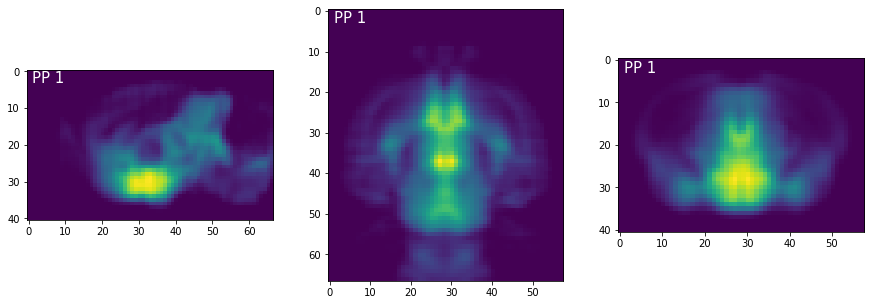

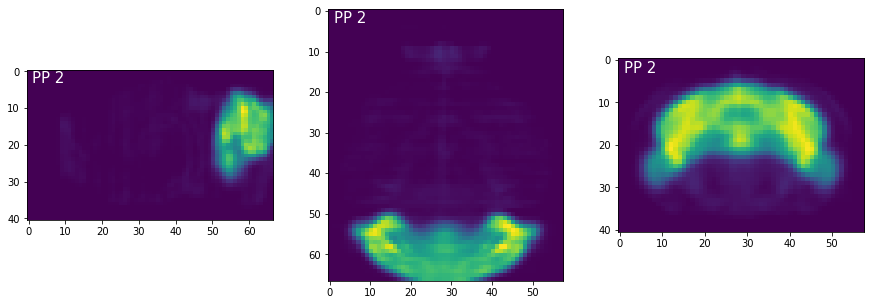

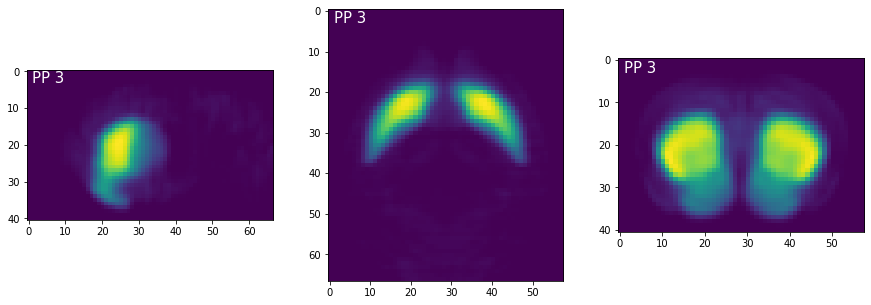

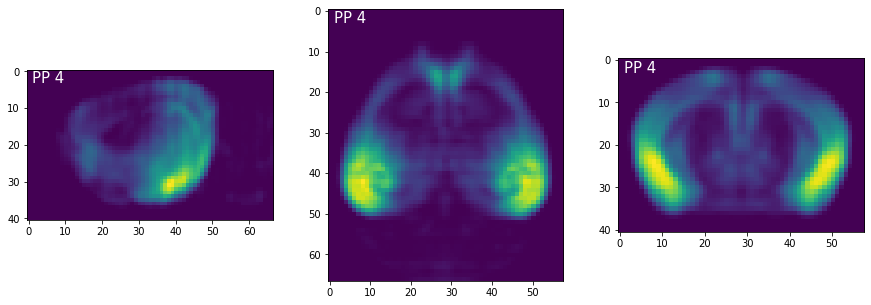

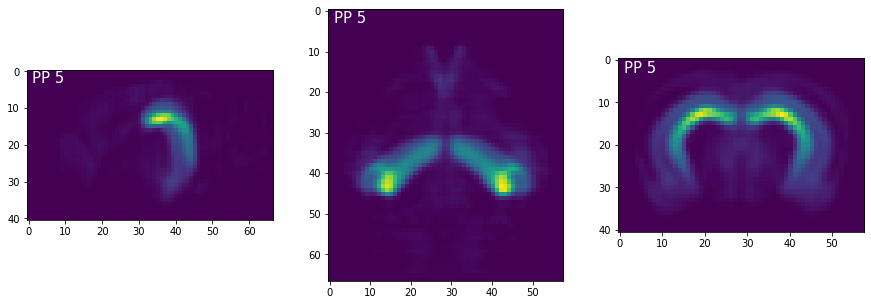

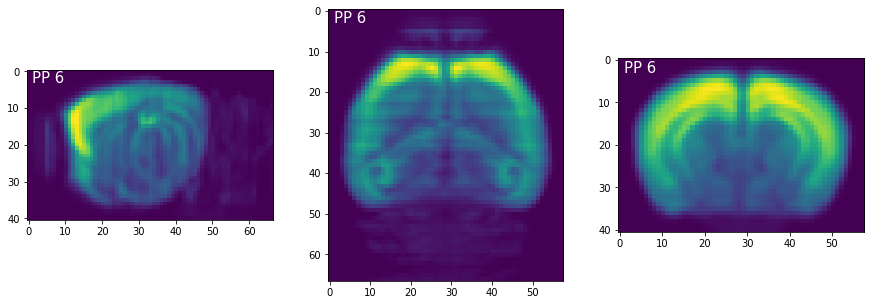

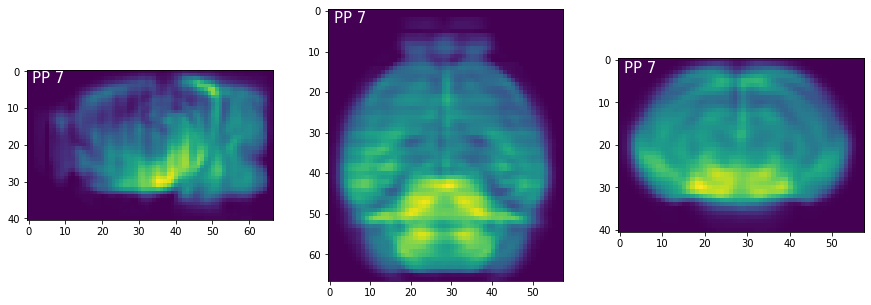

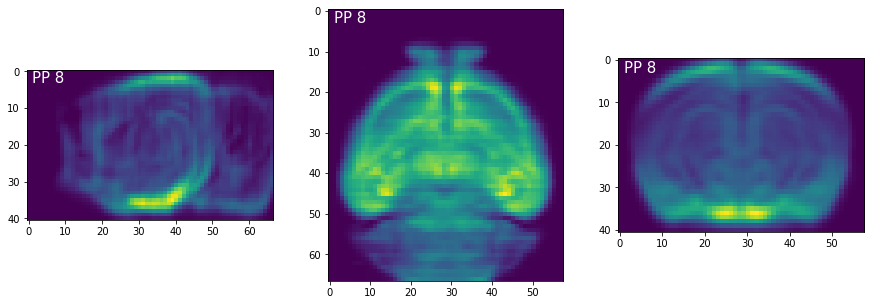

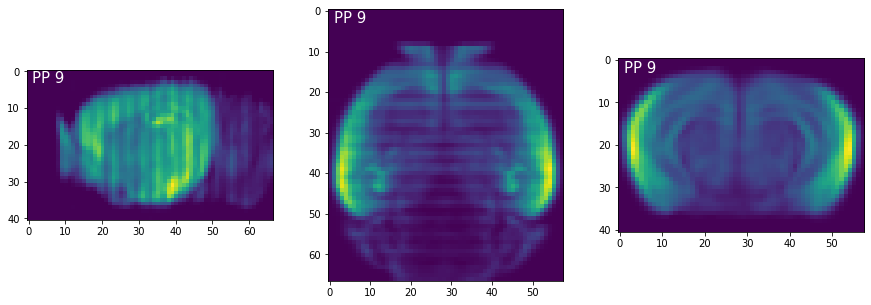

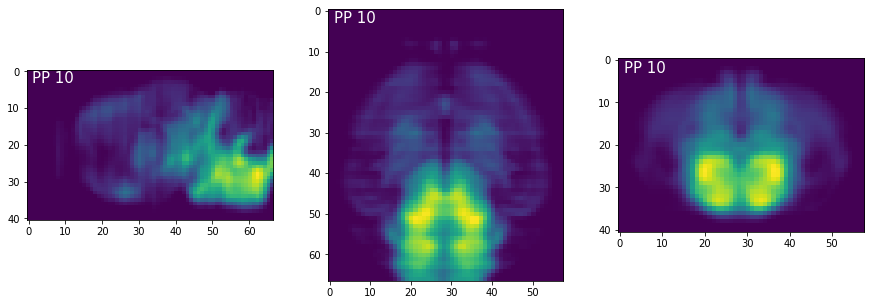

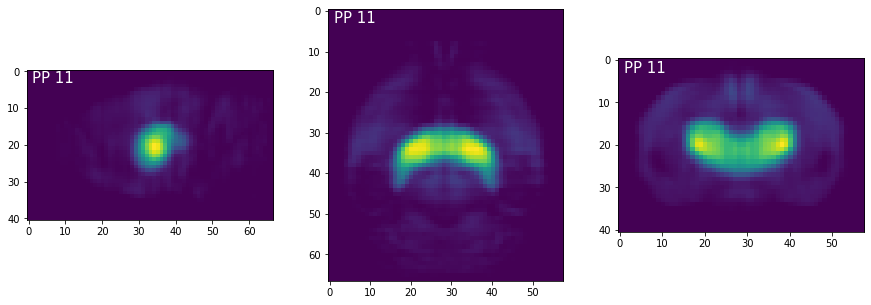

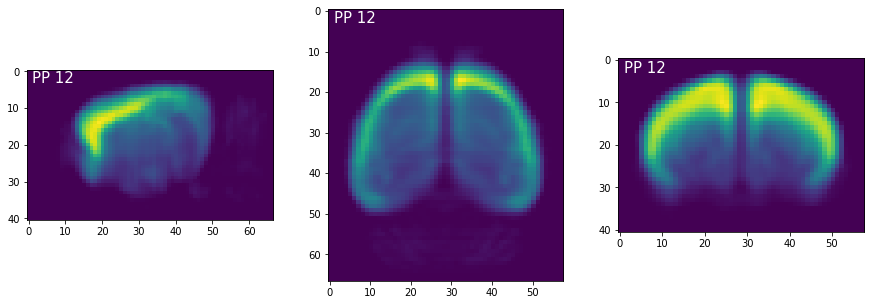

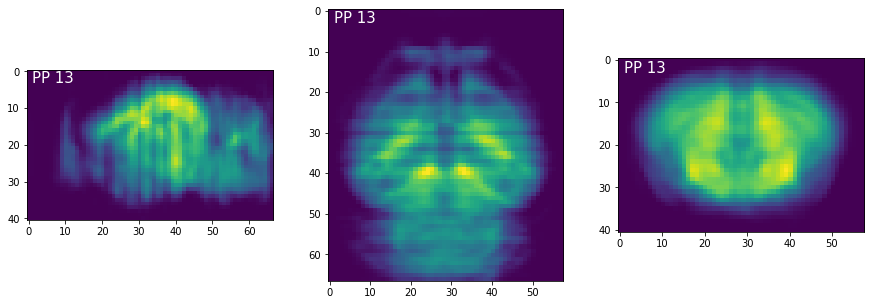

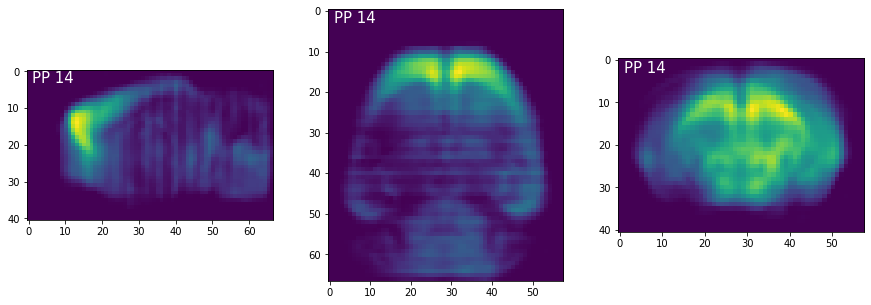

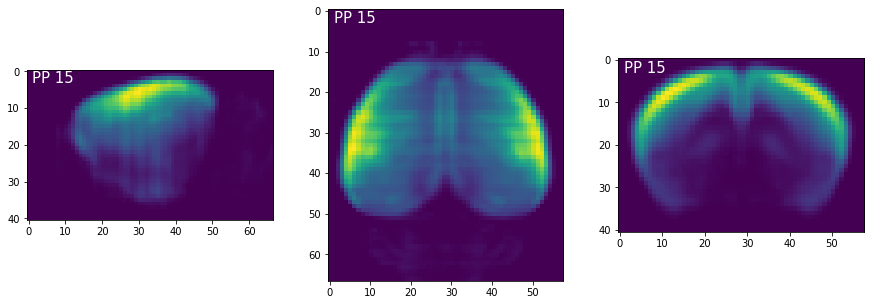

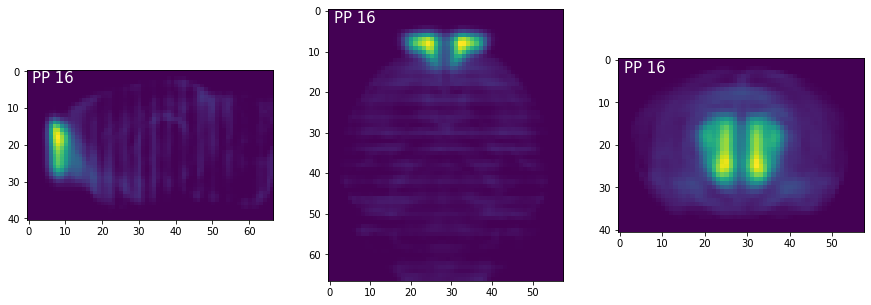

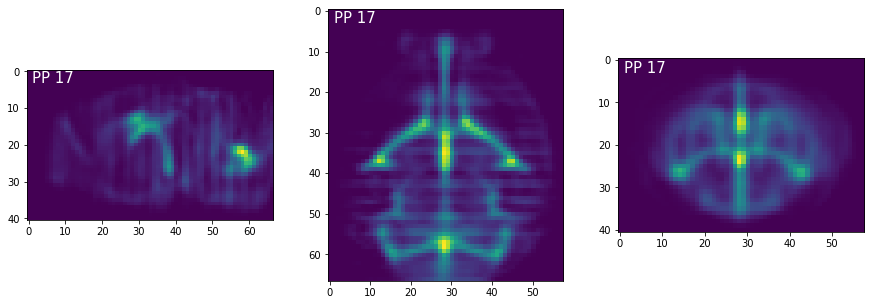

In [30]:
D_shrink = np.maximum(D_cube - 0, 0)
for i in range(18):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    a.imshow(np.mean(D_shrink[i, :, :, :], 2).T)
    b.imshow(np.mean(D_shrink[i, :, :, :], 1))
    c.imshow(np.mean(D_shrink[i, :, :, :], 0))
    a.text(1, 3, 'PP {}'.format(i), color='w', fontsize=15)
    b.text(1, 3, 'PP {}'.format(i), color='w', fontsize=15)
    c.text(1, 3, 'PP {}'.format(i), color='w', fontsize=15)

### compute the local linear network

In [204]:
def filter_genes(coefs, pps, threshold = .99):
    large_coefs = np.max(coefs[:, pps], 1) 
    return large_coefs > np.quantile(large_coefs, threshold)
    

In [256]:
def weighted_correlation(A, weights):
    '''
    Compute the weighted correlation between columns of A using the weights.
    '''
    mean_A = np.sum(A * weights, 1, keepdims=True) / np.sum(weights)
    print(mean_A.shape)
    cov = (A - mean_A) @ (A - mean_A).T
    corr = np.diag(np.diag(cov) ** -.5) @ cov @ np.diag(np.diag(cov)**-.5)
    return corr

In [282]:
#pps = [16, 14, 6]
pps = [5, 13, 12]
#pps = [4,8,9]
weights = np.mean(A[pps], 0)
selected_gene_ids = filter_genes(coefs, pps)
correlations = weighted_correlation(X_guess[selected_gene_ids,:], weights)
#correlations = np.corrcoef(X_guess[selected_gene_ids,:] * weights ** .5) 
selected_gene_names = np.array([name for gene_ind, name in sections.items()])[selected_gene_ids]

(44, 1)


In [283]:
correlations

array([[1.        , 0.96287018, 0.98642612, ..., 0.76761101, 0.93599075,
        0.88378631],
       [0.96287018, 1.        , 0.96643863, ..., 0.82325061, 0.94236112,
        0.90409865],
       [0.98642612, 0.96643863, 1.        , ..., 0.79023855, 0.93032102,
        0.90494996],
       ...,
       [0.76761101, 0.82325061, 0.79023855, ..., 1.        , 0.80989833,
        0.78784792],
       [0.93599075, 0.94236112, 0.93032102, ..., 0.80989833, 1.        ,
        0.85949613],
       [0.88378631, 0.90409865, 0.90494996, ..., 0.78784792, 0.85949613,
        1.        ]])

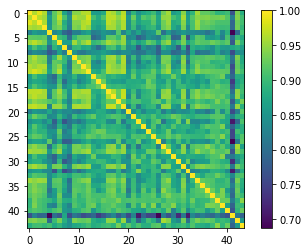

In [284]:
plt.imshow(correlations)
plt.colorbar()
plt.show()

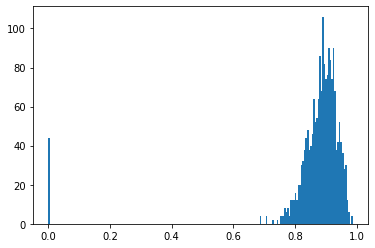

In [285]:
plt.hist((correlations - np.eye(correlations.shape[0])).flatten(),200)
plt.show()

In [286]:
import networkx as nx

In [287]:
corr_matrix = np.corrcoef(selected_genes * weights ** .5) - np.eye(selected_genes.shape[0])
#lower_bound = np.percentile(corr_matrix.flatten(), 5)
upper_bound = np.percentile(corr_matrix.flatten(), 98)
adj_matrix = corr_matrix > upper_bound
#adj_matrix = 0

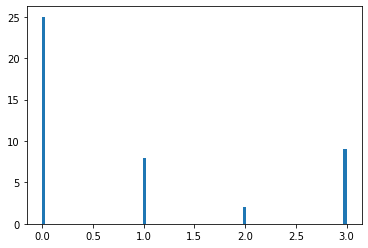

In [288]:
plt.hist(np.sum(adj_matrix, 0),100)
plt.show()

In [289]:
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    
    remove = [node for node,degree in gr.degree() if degree <= 0.5]
    
    gr.remove_nodes_from(remove)
    nodes = set(ind for ind, name in gr.degree())
    pos = nx.spring_layout(gr,k=1.2,iterations=70)
    nx.draw(gr, pos, node_size=2000, labels={k:v for k, v in mylabels.items() if k in nodes}, with_labels=True)
    plt.show()
    #print("There are {} connected components, plot each connected components that has more than one node".format(len(nx.connected_components(gr))))
    # draw each connected components
    for c in sorted(nx.connected_components(gr), key=len, reverse=True):
        if len(c) == 1:
            continue
        plt.figure()
        nx.draw(gr.subgraph(c), pos, node_size=2000, labels={k:v for k, v in mylabels.items() if k in c}, with_labels=True)
        plt.show()

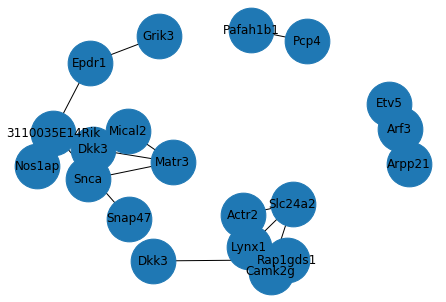

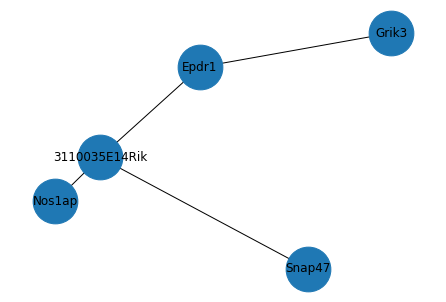

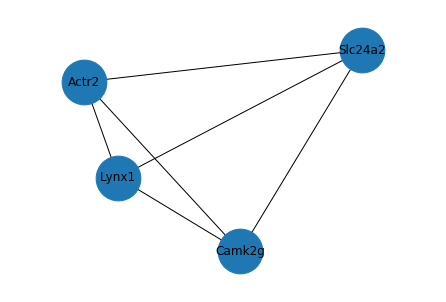

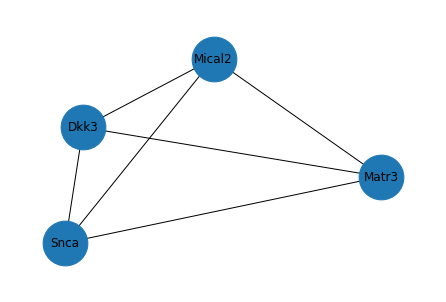

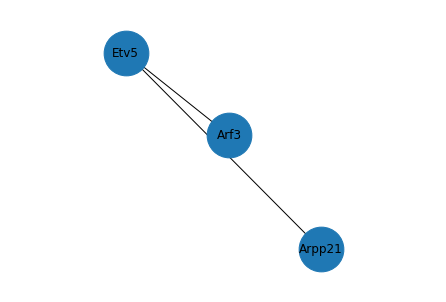

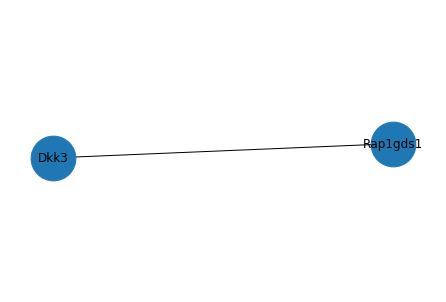

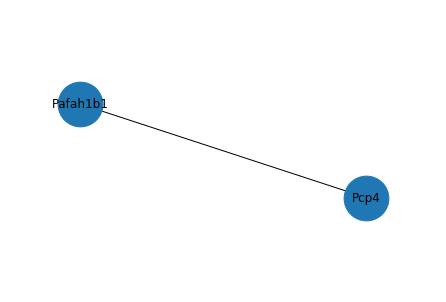

In [290]:
show_graph_with_labels(adj_matrix, {ind: name for ind, name in enumerate(selected_gene_names)})

- look at the genes in the cluster
- stability analysis
- correlation between atoms in the dictionary